In [1]:
import torch

from rl4co.envs import TSPEnv
from rl4co.models import AttentionModelPolicy, REINFORCE
from rl4co.utils.trainer import RL4COTrainer

/Users/vitaliypozdnyakov/miniconda3/envs/mtrlgnn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# RL4CO env based on TorchRL
env = TSPEnv(generator_params={'num_loc': 50})

# Policy: neural network, in this case with encoder-decoder architecture
policy = AttentionModelPolicy(env_name=env.name, 
                              embed_dim=128,
                              num_encoder_layers=3,
                              num_heads=8,
                            )

# RL Model: REINFORCE and greedy rollout baseline
model = REINFORCE(env, 
                    policy,
                    baseline="rollout",
                    batch_size=512,
                    train_data_size=100_000,
                    val_data_size=10_000,
                    optimizer_kwargs={"lr": 1e-4},
                    ) 

/Users/vitaliypozdnyakov/miniconda3/envs/mtrlgnn/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/Users/vitaliypozdnyakov/miniconda3/envs/mtrlgnn/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


Problem 1 | Cost: 19.570
Problem 2 | Cost: 19.358
Problem 3 | Cost: 21.248


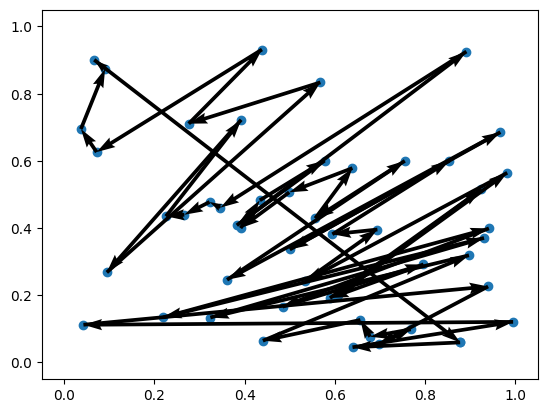

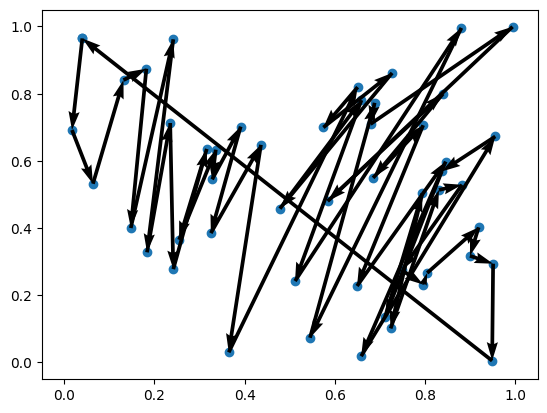

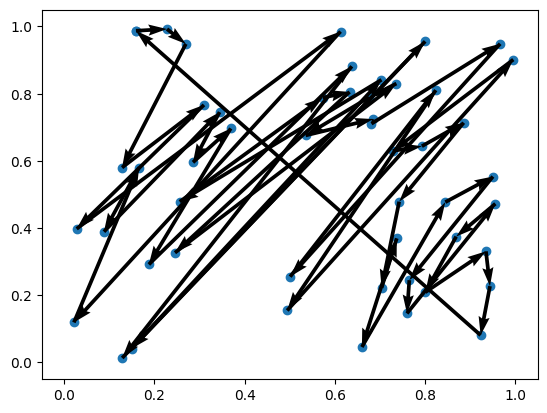

In [3]:
# Greedy rollouts over untrained policy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
policy = policy.to(device)
out = policy(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_untrained = out['actions'].cpu().detach()
rewards_untrained = out['reward'].cpu().detach()

for i in range(3):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])

In [18]:
actions_untrained[0]

tensor([11,  7, 28, 14,  1, 26, 30, 41, 32, 47, 16, 36, 24, 45, 43, 38, 42, 35,
        31,  2, 34, 18,  8, 20,  9, 49, 19,  3, 37, 29, 48, 25, 13, 40, 27, 10,
         0, 33, 44,  4, 46, 21, 22,  6,  5, 17, 39, 15, 12, 23])

In [4]:
td_init

TensorDict(
    fields={
        action_mask: Tensor(shape=torch.Size([3, 50]), device=cpu, dtype=torch.bool, is_shared=False),
        current_node: Tensor(shape=torch.Size([3]), device=cpu, dtype=torch.int64, is_shared=False),
        done: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        first_node: Tensor(shape=torch.Size([3]), device=cpu, dtype=torch.int64, is_shared=False),
        i: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        locs: Tensor(shape=torch.Size([3, 50, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        reward: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        terminated: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([3]),
    device=cpu,
    is_shared=False)

In [16]:
init_locs = torch.rand((1, 20, 2))
from tensordict.tensordict import TensorDict
td = TensorDict({'locs': init_locs})
TSPEnv()._reset(td, batch_size=[1])

TensorDict(
    fields={
        action_mask: Tensor(shape=torch.Size([1, 20]), device=cpu, dtype=torch.bool, is_shared=False),
        current_node: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, is_shared=False),
        first_node: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, is_shared=False),
        i: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        locs: Tensor(shape=torch.Size([1, 20, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        reward: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([1]),
    device=None,
    is_shared=False)

In [4]:
trainer = RL4COTrainer(
    max_epochs=3,
    accelerator="gpu",
    devices=1,
    logger=None,
)

Using 16bit Automatic Mixed Precision (AMP)
/Users/vitaliypozdnyakov/miniconda3/envs/multitaskgnn/lib/python3.11/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/vitaliypozdnyakov/miniconda3/envs/multitaskgnn/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [5]:
trainer.fit(model)

val_file not set. Generating dataset instead
test_file not set. Generating dataset instead

  | Name     | Type                 | Params | Mode 
----------------------------------------------------------
0 | env      | TSPEnv               | 0      | train
1 | policy   | AttentionModelPolicy | 710 K  | train
2 | baseline | WarmupBaseline       | 710 K  | train
----------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.681     Total estimated model params size (MB)
72        Modules in train mode
68        Modules in eval mode


Sanity Checking DataLoader 0:   0%|                                                              | 0/2 [00:00<?, ?it/s]

/Users/vitaliypozdnyakov/miniconda3/envs/multitaskgnn/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/vitaliypozdnyakov/miniconda3/envs/multitaskgnn/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


/Users/vitaliypozdnyakov/miniconda3/envs/multitaskgnn/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|███████████████████████| 196/196 [06:12<00:00,  0.53it/s, v_num=0, train/reward=-7.29, train/loss=-0.338]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████| 196/196 [06:17<00:00,  0.52it/s, v_num=0, train/reward=-6.67, train/loss=-1.27, val/reward=-6.63]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████| 196/196 [06:11<00:00,  0.53it/s, v_num=0, train/reward=-6.58, train/loss=-1.21, val/reward=-6.47]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████| 196/196 [06:24<00:00,  0.51it/s, v_num=0, train/reward=-6.58, train/loss=-1.21, val/reward=-6.38]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████| 196/196 [06:52<00:00,  0.47it/s, v_num=0, train/reward=-6.58, train/loss=-1.21, val/reward=-6.38]


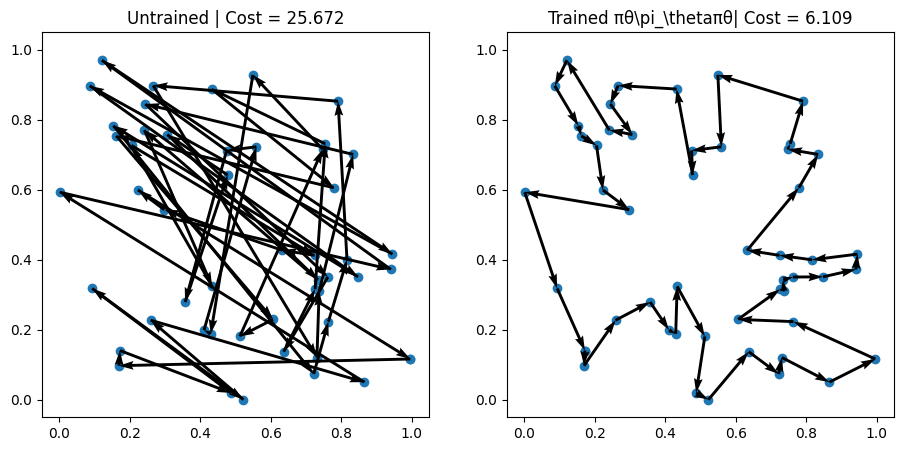

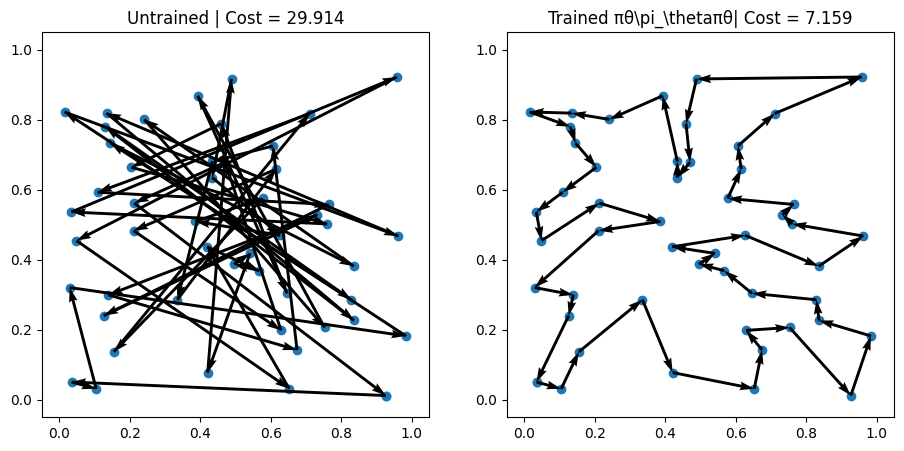

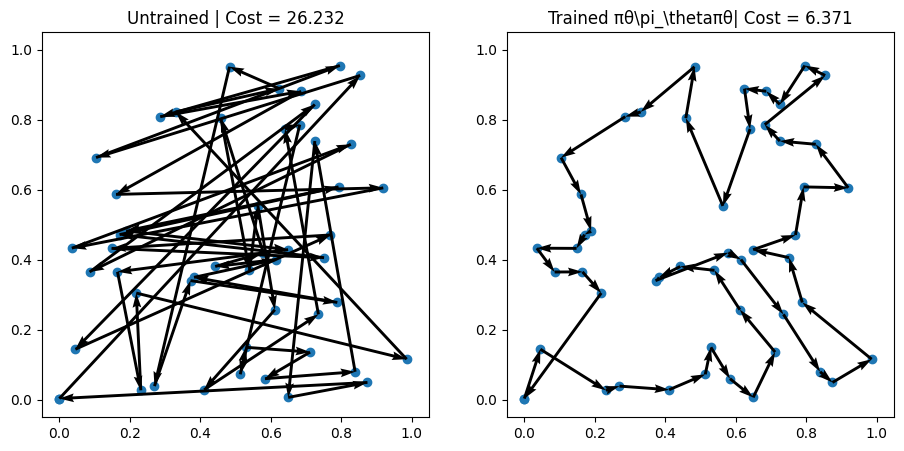

In [6]:
# Greedy rollouts over trained model (same states as previous plot)
policy = model.policy.to(device)
out = policy(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))
    env.render(td, actions_untrained[i], ax=axs[0]) 
    env.render(td, actions_trained[i], ax=axs[1])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}")
    axs[1].set_title(r"Trained πθ\pi_\thetaπθ​" + f"| Cost = {-out['reward'][i].item():.3f}")

No action in TensorDict, rendering unsorted locs


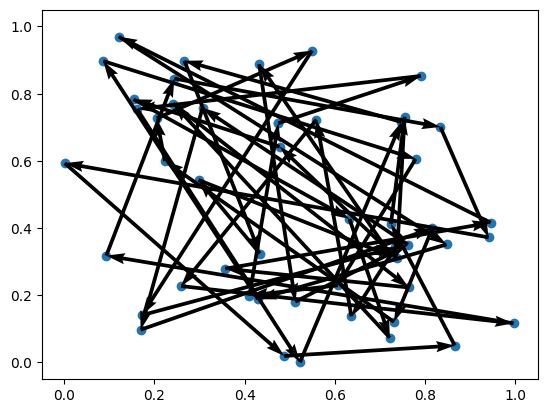

In [12]:
env

In [15]:
td_init[0]['locs']

tensor([[4.7478e-01, 7.1216e-01],
        [7.9119e-01, 8.5298e-01],
        [1.6163e-01, 7.5414e-01],
        [5.2257e-01, 4.4340e-04],
        [7.4765e-01, 7.1574e-01],
        [2.6636e-01, 8.9792e-01],
        [4.3379e-01, 3.2405e-01],
        [2.9779e-01, 5.4314e-01],
        [7.2609e-01, 3.1584e-01],
        [4.3218e-01, 8.8777e-01],
        [5.1239e-01, 1.8098e-01],
        [7.6226e-01, 3.5072e-01],
        [3.0663e-01, 7.5774e-01],
        [1.6935e-01, 9.7369e-02],
        [8.1661e-01, 3.9987e-01],
        [7.3126e-01, 1.2075e-01],
        [2.2309e-01, 5.9938e-01],
        [2.0493e-01, 7.2663e-01],
        [5.4940e-01, 9.2818e-01],
        [1.7201e-01, 1.4074e-01],
        [7.3436e-01, 3.4265e-01],
        [6.3688e-01, 1.3732e-01],
        [5.5930e-01, 7.2277e-01],
        [2.5911e-01, 2.2740e-01],
        [9.9640e-01, 1.1648e-01],
        [9.3238e-02, 3.1799e-01],
        [2.4418e-01, 8.4495e-01],
        [8.3414e-01, 7.0096e-01],
        [9.4104e-01, 3.7240e-01],
        [1.092

In [11]:
actions_untrained[0]

tensor([24, 13, 19, 30, 25,  3, 23, 31, 29, 28, 43, 42, 46, 44, 36, 38, 40, 14,
         1,  5, 15, 34, 27, 26, 11, 21,  8, 33,  9, 47,  2, 48, 10,  4, 18, 45,
        49, 22,  0, 41, 35, 12, 20, 39,  6, 17, 32, 37,  7, 16])

In [16]:
env.reset()

TensorDict(
    fields={
        action_mask: Tensor(shape=torch.Size([50]), device=cpu, dtype=torch.bool, is_shared=False),
        current_node: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=mps:0, dtype=torch.bool, is_shared=False),
        first_node: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
        i: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, is_shared=False),
        locs: Tensor(shape=torch.Size([50, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        reward: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        terminated: Tensor(shape=torch.Size([1]), device=mps:0, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)